In [44]:
## SALIENCY MAPS ON PRE-TRAINED MODELS

# 📚 bring in my libraries!
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.vgg16 import decode_predictions

import numpy as np

# our old friend ...
import matplotlib.pyplot as plt

# check that tensorflow installed correctly
print('tensorflow {}'.format(tf.__version__))



tensorflow 2.14.0


In [45]:
# VGG16 is a pre-trained model, available via tensorflow
# VGG16 is a neural network architecture particularly good @ image classification
# keras = the API that talks to tensorflow

model = keras.applications.VGG16(weights='imagenet')

In [46]:
model.summary()

# gives me the summary of the model we've downloaded (VGG16)
# check it out: there are 16 "layers" to the model
# each layer in a neural network represents a series of operations
# performed on the input data as it propagates through the network
# on its way to producing the final output

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

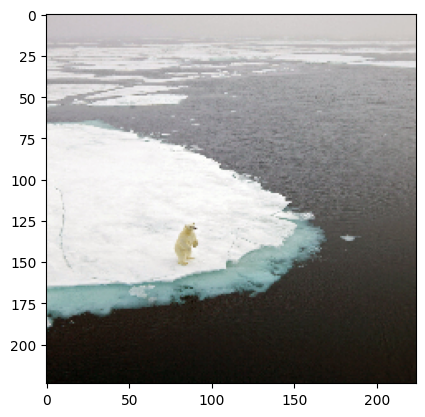

In [55]:
# load in an image!
# the dimensions here (224x224 pixels) need to match what the pre-trained model expects

_img = keras.preprocessing.image.load_img('/content/bear.jpg',target_size=(224,224))
plt.imshow(_img)
plt.show()


In [56]:
# preprocess image to get it into the right format for the model

img = keras.preprocessing.image.img_to_array(_img)
# this line converts to image to a NumPy array of pixels
# x, y, and RGB value - for every pixel (224 x 224 x 3)

img = img.reshape((1, *img.shape))
# more processing, adding a dimension ("batch") that the model expects
# a 4D array

y_pred = model.predict(img)
print(y_pred)
# an output of predictions from the image classification model
# each # is a "score" of how much the image is likely to be a certain class
# https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

1/1 [==============================] - 1s 1s/step
[[2.96002054e-06 4.23914798e-06 5.03038646e-05 3.03151446e-05
  2.68100812e-05 4.39254254e-05 1.10117217e-04 7.71256691e-06
  1.01904971e-05 1.34869097e-05 2.63092466e-06 9.05325294e-07
  6.73687225e-07 3.67154171e-05 1.89666014e-06 2.98713644e-06
  1.79461892e-06 1.27970543e-05 2.64131377e-05 1.03574030e-05
  6.25335233e-05 3.87669161e-06 6.77432981e-05 1.95528555e-05
  2.46074387e-06 1.41491626e-06 6.13945815e-07 5.26262966e-06
  9.28721590e-07 4.37529593e-07 1.46075809e-06 7.57392002e-07
  2.38179695e-07 3.50615068e-04 2.32161046e-03 1.26253080e-05
  1.23030868e-05 2.69467455e-06 2.42950455e-06 8.29845612e-06
  5.67450070e-06 1.05330514e-06 4.27696568e-06 2.00403534e-07
  2.56284488e-06 1.25637152e-05 6.99673637e-06 5.25940607e-07
  4.94398091e-06 1.49046773e-05 4.10167049e-05 1.85921260e-06
  6.76218860e-07 1.64818778e-06 3.97563235e-06 5.06608444e-07
  1.43528177e-06 1.16716183e-06 5.31504738e-05 8.45274315e-07
  2.96172038e-06 1.2

In [57]:
# this loops through the top 5 highest predicions in y_pred
# and links them to the associated categories (decode_predictions function is built-in)
# this prints out what the model "thinks" the image is
decoded_predictions = decode_predictions(y_pred, top=5)[0]
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")


1: seashore (0.24)
2: sandbar (0.21)
3: promontory (0.12)
4: alp (0.08)
5: volcano (0.04)


In [58]:
# BIG PICTURE: we are trying to get a measure of gradients of the input image
# and the output image, to determine which PARTS of the image are most important, predictive for the model

# gradient here is a measure of CHANGE: how much will the output change if you adjust the input?

# convert input image to tf.Variable, a multi-dimensional array for the model
images = tf.Variable(img, dtype=float)

# gradientTape() keeps track of all these gradients
# we're looking for the most likely class again (just in a different format)
with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]

grads = tape.gradient(loss, images)


In [59]:
# get absolute value
dgrad_abs = tf.math.abs(grads)

In [60]:
# looking for the maximum in the list of absolute gradient values
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

In [61]:
# normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)


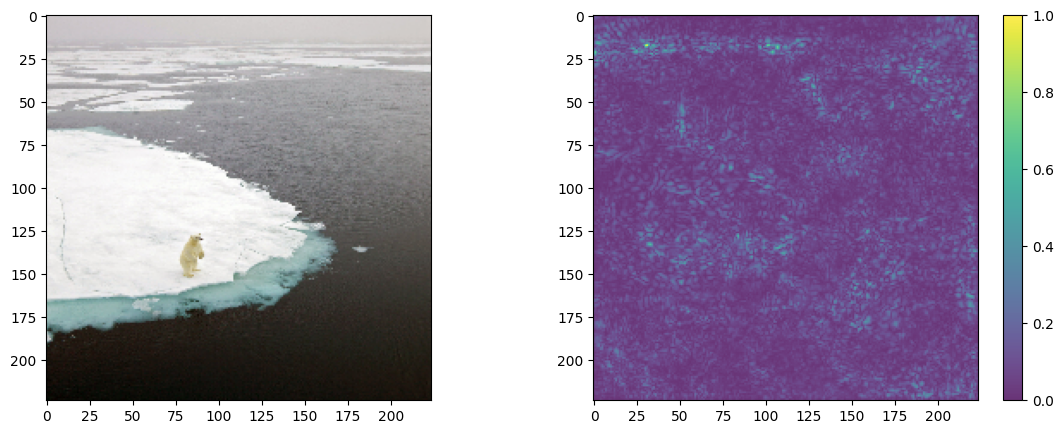

In [64]:
# NOW! we plot

# hello again, matplotlib ...
fig, axes = plt.subplots(1,2,figsize=(14,5))

# the first subplot = the input image
axes[0].imshow(_img)
# the second subplot is the SALIENCY MAP:
# MOST IMPORTANT pixels for the models prediction!
i = axes[1].imshow(grad_eval,cmap="viridis",alpha=0.8)
fig.colorbar(i)


In [65]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 1s 1s/step


IndexError: ignored

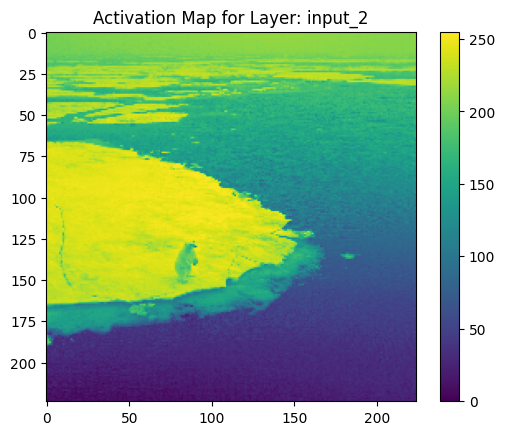

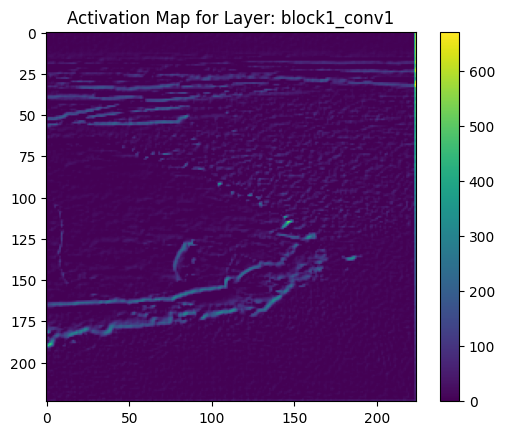

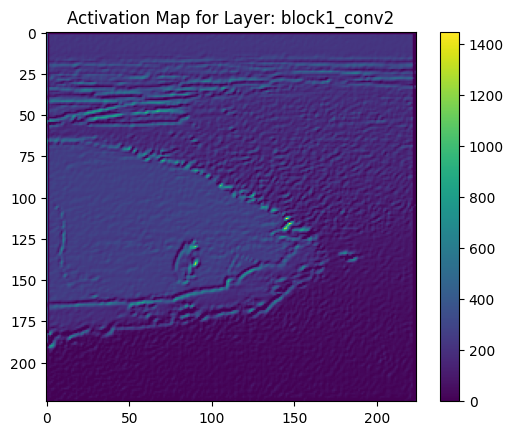

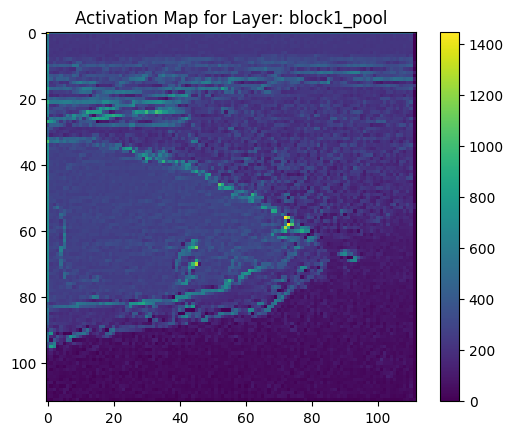

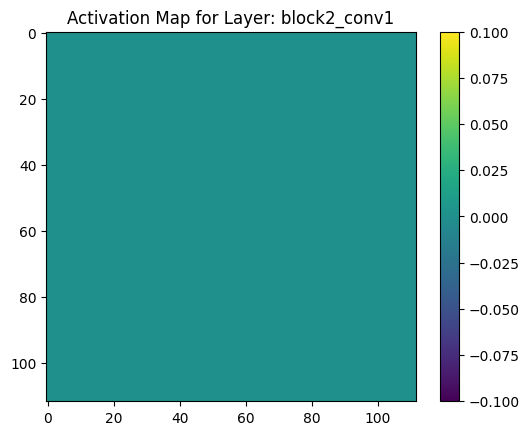

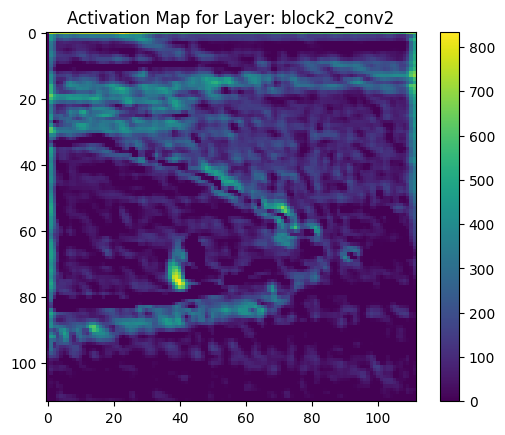

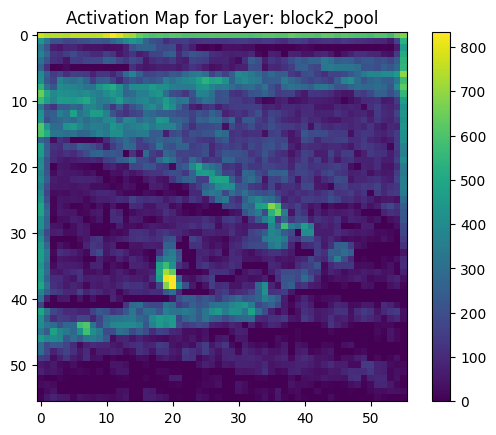

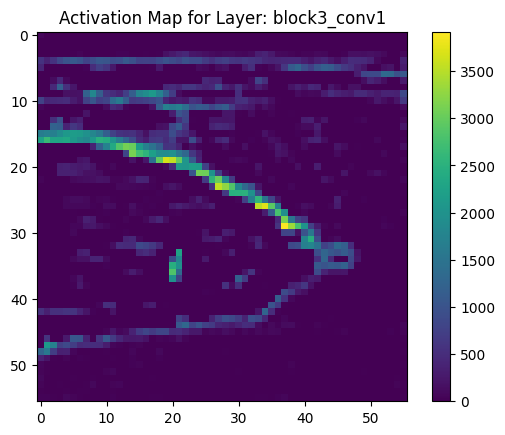

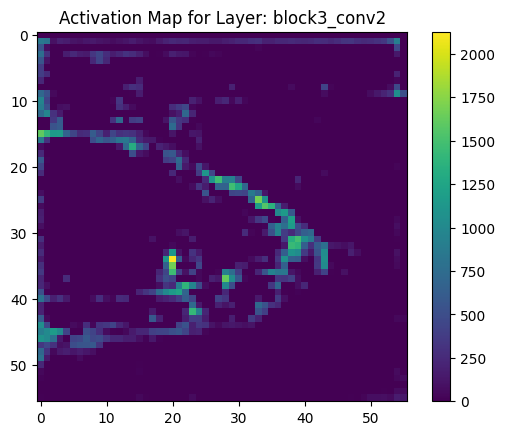

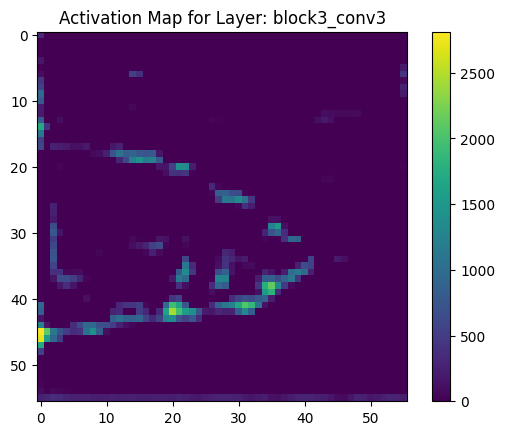

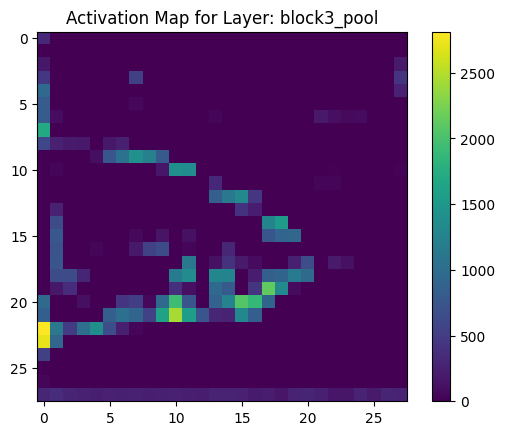

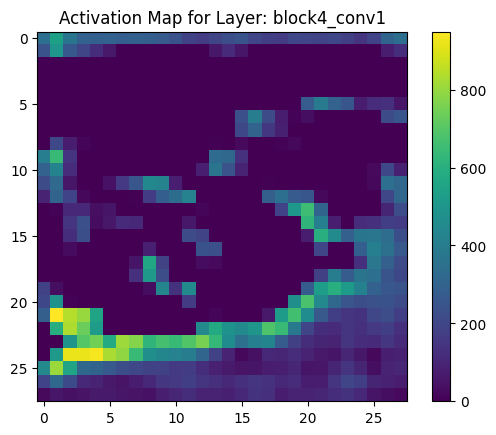

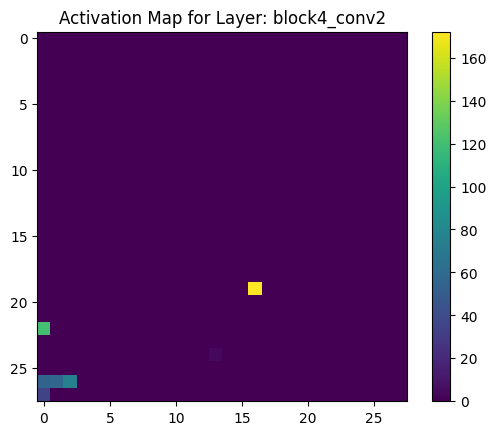

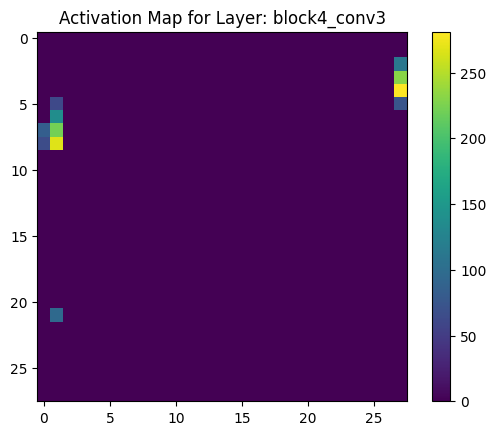

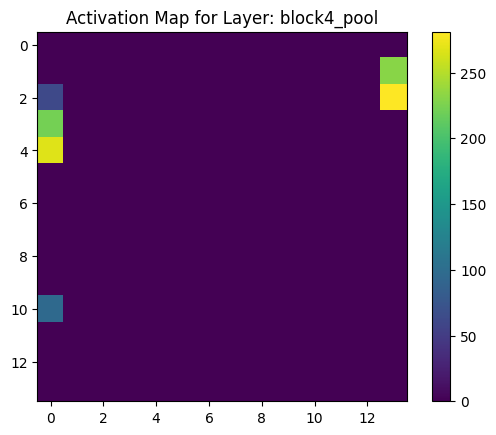

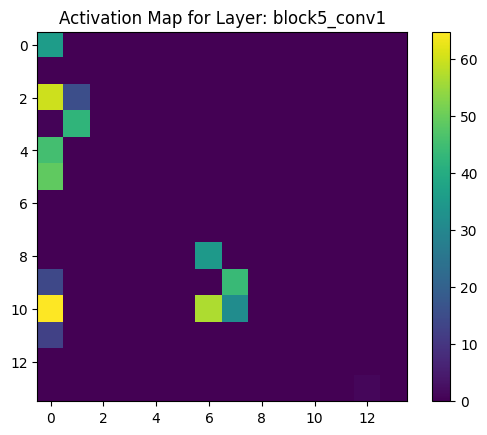

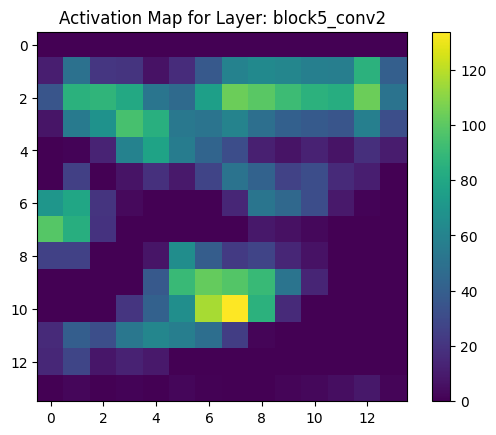

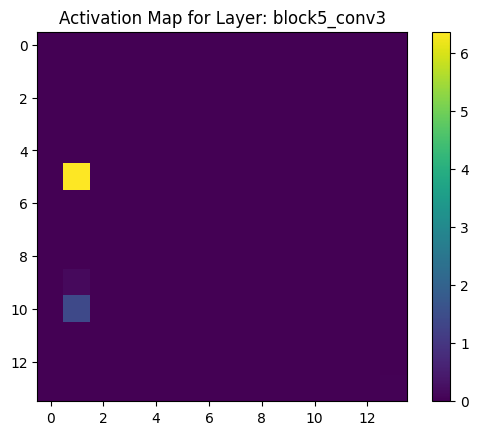

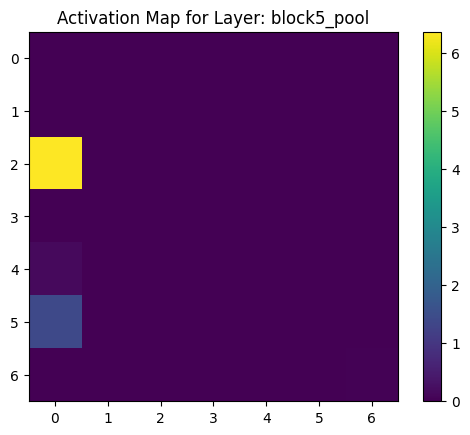

<Figure size 640x480 with 0 Axes>

In [66]:
# we can also show ACTIVATION MAP:
# what the process looks like for every "layer" in the model

# make a list of all the model's layers
layer_names = [layer.name for layer in model.layers]

# loop through each layer and visualize the activation map
for layer_name in layer_names:
    # create a model that outputs the activation map for the current layer
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # get the activation map for the input image
    activations = activation_model.predict(img)

    # display the activation map
    plt.figure()
    plt.imshow(activations[0, :, :, 0], cmap='viridis')
    plt.title(f'Activation Map for Layer: {layer_name}')
    plt.colorbar()

plt.show()
# show 'em all!


📸 Citations:

- https://usmanr149.github.io/urmlblog/cnn/2020/05/01/Salincy-Maps.html - (much of the code/idea for this demo comes from this post!)
- https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a (image classification categories)
- https://towardsdatascience.com/saliency-map-using-pytorch-68270fe45e80

1/1 [==============================] - 0s 476ms/step


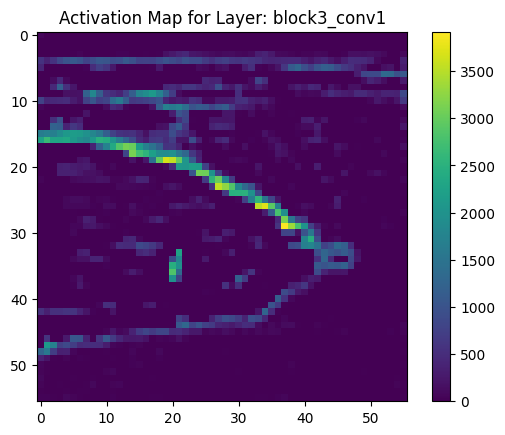

In [67]:
## BELOW: code for just 1 layer's activation map

# Define the layer for which you want to visualize the activation map
layer_name = 'block3_conv1'  # Change this to the desired layer

# Create a model that outputs the activation map for the specified layer
activation_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Get the activation map for the input image
activations = activation_model.predict(img)

# Visualize the activation map
plt.imshow(activations[0, :, :, 0], cmap='viridis')
plt.title(f'Activation Map for Layer: {layer_name}')
plt.colorbar()
plt.show()